Computing fixed optimal solution...
Optimal cost: 1307.84 km

Running statistical evaluation + ablations (20 seeds)...

Seed 1/20
  hybrid-fallback     QAOA (7 qubits, p=4)... .... done
  QAOA (6 qubits, p=4)... .... done
  QAOA (5 qubits, p=4)... .... done
  QAOA (4 qubits, p=4)... .... done
  QAOA (3 qubits, p=4)... .... done
  QAOA (2 qubits, p=4)... .... done
  QAOA (1 qubits, p=4)... .... done
 → ratio 1.034
  hybrid-no-fallback  QAOA (7 qubits, p=4)... .... done
  QAOA (6 qubits, p=4)... .... done
  QAOA (5 qubits, p=4)... .... done
  QAOA (4 qubits, p=4)... .... done
  QAOA (3 qubits, p=4)... .... done
  QAOA (2 qubits, p=4)... .... done
  QAOA (1 qubits, p=4)... .... done
 → ratio 1.034
  greedy             → ratio 1.135
  pure-two-opt       → ratio 1.011

Seed 2/20
  hybrid-fallback     QAOA (7 qubits, p=4)... .... done
  QAOA (6 qubits, p=4)... .... done
  QAOA (5 qubits, p=4)... .... done
  QAOA (4 qubits, p=4)... .... done
  QAOA (3 qubits, p=4)... .... done
  QAOA (2 qubit

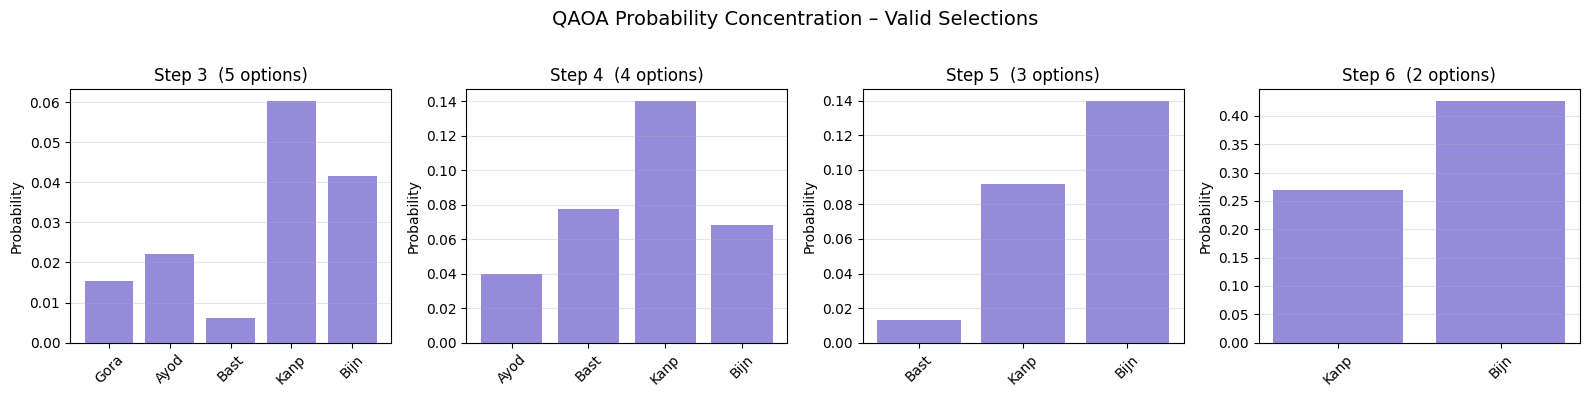

Probability plots saved: qaoa_prob_concentration.png

Done. Check console table and saved plot.


In [1]:
"""
Hybrid QAOA-Guided Travelling Salesman Problem Solver - Enhanced Version
======================================================================
Original + statistical evaluation (20 seeds), ablation study, probability plots

New features:
- Performance statistics over 20 seeds
- Ablation: pure greedy, pure 2-opt, hybrid without fallback
- Probability concentration plots for small subproblems
"""

import math
import random
import numpy as np
from itertools import permutations
from math import radians, sin, cos, sqrt, atan2
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
import pandas as pd

# ============================================================================
# 1. DATASET
# ============================================================================
CITIES = {
    "Lucknow": (26.8467, 80.9462),
    "Bijnor": (29.3732, 78.1351),
    "Kanpur": (26.4499, 80.3319),
    "Basti": (26.8140, 82.7630),
    "Ayodhya": (26.7991, 82.2047),
    "Gorakhpur": (26.76060, 83.3732),
    "Gonda": (27.1339, 81.9620),
    "Sitapur": (27.5680, 80.6790)
}
CITY_LIST = ["Lucknow"] + [c for c in CITIES if c != "Lucknow"]
N_CITIES = len(CITY_LIST)

def haversine(c1: str, c2: str) -> float:
    lat1, lon1 = CITIES[c1]
    lat2, lon2 = CITIES[c2]
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

DIST_MATRIX = np.array([[haversine(CITY_LIST[i], CITY_LIST[j]) for j in range(N_CITIES)]
                        for i in range(N_CITIES)])

def route_cost(indices: list[int]) -> float:
    total = sum(DIST_MATRIX[indices[i], indices[i+1]] for i in range(len(indices)-1))
    total += DIST_MATRIX[indices[-1], indices[0]]
    return total

# ============================================================================
# 2. CLASSICAL BASELINES
# ============================================================================
def compute_optimal_brute_force():
    best_cost = float('inf')
    best_route = None
    for perm in permutations(range(1, N_CITIES)):
        route = [0] + list(perm)
        cost = route_cost(route)
        if cost < best_cost:
            best_cost = cost
            best_route = route
    names = [CITY_LIST[i] for i in best_route] + [CITY_LIST[0]]
    return names, best_cost

def greedy_tour():
    unvisited = set(range(1, N_CITIES))
    tour = [0]
    while unvisited:
        curr = tour[-1]
        dists = [DIST_MATRIX[curr, idx] for idx in unvisited]
        next_idx = list(unvisited)[np.argmin(dists)]
        tour.append(next_idx)
        unvisited.remove(next_idx)
    tour.append(0)
    return tour, route_cost(tour)

def pure_two_opt_start_random():
    route = [0] + random.sample(range(1, N_CITIES), N_CITIES-1)
    route.append(0)
    refined = two_opt_refinement(route[:-1])
    refined.append(0)
    return refined, route_cost(refined)

def two_opt_refinement(indices: list[int]) -> list[int]:
    best = indices.copy()
    improved = True
    while improved:
        improved = False
        for i in range(1, len(best)-2):
            for j in range(i+1, len(best)-1):
                candidate = best[:i] + best[i:j+1][::-1] + best[j+1:]
                if route_cost(candidate) < route_cost(best):
                    best = candidate
                    improved = True
                    break
            if improved: break
    return best

# ============================================================================
# 3. QUANTUM COMPONENTS
# ============================================================================
def build_hamiltonian(current: int, remaining: set[int]) -> qml.Hamiltonian | None:
    num_qubits = len(remaining)
    if num_qubits == 0:
        return None
    rem_list = list(remaining)
    max_dist = max(DIST_MATRIX[current, idx] for idx in rem_list)
    penalty = max_dist * 5.0
    coeffs, ops = [], []
    # Linear terms for distances
    for i, idx in enumerate(rem_list):
        dist = DIST_MATRIX[current, idx]
        coeffs.extend([dist / 2, -dist / 2])
        ops.extend([qml.Identity(i), qml.PauliZ(i)])
    # Exactly-one penalty (quadratic form)
    coeffs.append(penalty * (num_qubits - 1)**2 / 4)
    ops.append(qml.Identity(0))
    for i in range(num_qubits):
        coeffs.append(-penalty * (num_qubits - 2) / 2)
        ops.append(qml.PauliZ(i))
    for i in range(num_qubits):
        for j in range(i+1, num_qubits):
            coeffs.append(penalty / 2)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))
    return qml.Hamiltonian(coeffs, ops)

def run_qaoa_next_city(current: int, remaining: set[int],
                       p_layers: int = 4, n_steps: int = 120,
                       use_fallback: bool = True,
                       return_probs: bool = False):
    num_qubits = len(remaining)
    if num_qubits == 0:
        return None, None if return_probs else None

    H = build_hamiltonian(current, remaining)
    if H is None:
        return list(remaining)[0], None if return_probs else list(remaining)[0]

    dev = qml.device("lightning.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def cost_circuit(params):
        gammas, betas = params[:p_layers], params[p_layers:]
        for w in range(num_qubits): qml.Hadamard(w)
        for layer in range(p_layers):
            qml.ApproxTimeEvolution(H, gammas[layer], 1)
            for w in range(num_qubits):
                qml.RX(2 * betas[layer], wires=w)
        return qml.expval(H)

    @qml.qnode(dev)
    def prob_circuit(params):
        gammas, betas = params[:p_layers], params[p_layers:]
        for w in range(num_qubits): qml.Hadamard(w)
        for layer in range(p_layers):
            qml.ApproxTimeEvolution(H, gammas[layer], 1)
            for w in range(num_qubits):
                qml.RX(2 * betas[layer], wires=w)
        return qml.probs(wires=range(num_qubits))

    optimizer = AdamOptimizer(stepsize=0.08)
    params = pnp.random.uniform(0, np.pi, 2 * p_layers, requires_grad=True)

    print(f"  QAOA ({num_qubits} qubits, p={p_layers})... ", end="")
    for step in range(n_steps):
        params = optimizer.step(cost_circuit, params)
        if step % 30 == 0: print(".", end="", flush=True)
    print(" done")

    final_energy = float(cost_circuit(params))
    probs = prob_circuit(params)

    best_prob, best_city = 0, None
    for state in range(2**num_qubits):
        bitstring = format(state, f'0{num_qubits}b')
        if bitstring.count('1') == 1:
            pos = bitstring.index('1')
            city = list(remaining)[pos]
            if probs[state] > best_prob:
                best_prob = probs[state]
                best_city = city

    if best_city is None or (use_fallback and best_prob < 0.01):
        print(f"  Low confidence ({best_prob:.3f}) → fallback")
        dists = [DIST_MATRIX[current, idx] for idx in remaining]
        best_city = list(remaining)[np.argmin(dists)]
        best_prob = 0.0

    if return_probs:
        return best_city, probs
    else:
        return best_city, None

def build_hybrid_tour(use_fallback=True, collect_probs_for_steps=None):
    unvisited = set(range(1, N_CITIES))
    tour = [0]
    total = 0.0
    prob_data = []  # list of (step, remaining_count, probs)

    step = 0
    while unvisited:
        step += 1
        curr = tour[-1]
        rem_count = len(unvisited)

        collect = collect_probs_for_steps is not None and rem_count in collect_probs_for_steps

        next_city, probs = run_qaoa_next_city(
            curr, unvisited,
            p_layers=4, n_steps=120,
            use_fallback=use_fallback,
            return_probs=collect
        )

        tour.append(next_city)
        unvisited.remove(next_city)
        total += DIST_MATRIX[curr, next_city]

        if collect:
            prob_data.append((step, rem_count, probs))

    total += DIST_MATRIX[tour[-1], 0]
    tour.append(0)
    names = [CITY_LIST[i] for i in tour]
    return names, total, prob_data

# ============================================================================
# 4. STATISTICAL EVALUATION + ABLATION
# ============================================================================
def run_with_seed(seed: int, mode: str = "hybrid-fallback", collect_probs=False):
    random.seed(seed)
    np.random.seed(seed)
    pnp.random.seed(seed)

    optimal_names, optimal_cost = compute_optimal_brute_force()

    if mode == "pure-two-opt":
        tour, cost = pure_two_opt_start_random()
        refined_tour = two_opt_refinement(tour[:-1]) + [0]
        refined_cost = route_cost(refined_tour)
        return refined_cost, optimal_cost, None

    elif mode == "greedy":
        _, cost = greedy_tour()
        return cost, optimal_cost, None

    elif mode in ["hybrid-fallback", "hybrid-no-fallback"]:
        use_fallback = (mode == "hybrid-fallback")
        collect = [2,3,4,5] if collect_probs else None
        names, raw_cost, prob_data = build_hybrid_tour(use_fallback=use_fallback, collect_probs_for_steps=collect)
        refined_indices = two_opt_refinement([CITY_LIST.index(c) for c in names[:-1]]) + [0]
        refined_cost = route_cost(refined_indices)
        return refined_cost, optimal_cost, prob_data

    raise ValueError("Unknown mode")

def run_statistics(n_seeds=20):
    modes = ["hybrid-fallback", "hybrid-no-fallback", "greedy", "pure-two-opt"]
    results = {m: [] for m in modes}
    prob_collections = []  # only from first hybrid run with fallback

    optimal_cost = compute_optimal_brute_force()[1]

    for seed in range(n_seeds):
        print(f"\nSeed {seed+1}/{n_seeds}")
        for mode in modes:
            print(f"  {mode:18}", end="")
            cost, opt, probs = run_with_seed(seed, mode=mode,
                                             collect_probs=(mode=="hybrid-fallback" and seed==0))
            ratio = cost / opt
            results[mode].append(ratio)
            print(f" → ratio {ratio:.3f}")

            if probs is not None:
                prob_collections.extend(probs)

    # Summary table
    data = []
    for mode in modes:
        ratios = results[mode]
        mean_r = np.mean(ratios)
        std_r  = np.std(ratios)
        min_r  = np.min(ratios)
        max_r  = np.max(ratios)
        data.append([mode, f"{mean_r:.3f} ± {std_r:.3f}", f"{min_r:.3f}", f"{max_r:.3f}"])

    df = pd.DataFrame(data, columns=["Method", "Mean ratio ± std", "Best", "Worst"])
    print("\n" + "="*70)
    print("STATISTICAL PERFORMANCE OVER 20 SEEDS (lower ratio = better)")
    print("="*70)
    print(df.to_string(index=False))
    print(f"\nOptimal cost (fixed): {optimal_cost:.2f} km\n")

    return prob_collections

# ============================================================================
# 5. PROBABILITY CONCENTRATION PLOTS
# ============================================================================
def plot_probability_concentrations(prob_data):
    if not prob_data:
        print("No probability data collected.")
        return

    fig, axes = plt.subplots(1, len(prob_data), figsize=(4*len(prob_data), 4))
    if len(prob_data) == 1:
        axes = [axes]

    for ax, (step, rem_count, full_probs) in zip(axes, prob_data):
        valid_probs = []
        labels = []
        for state in range(2**rem_count):
            bits = format(state, f'0{rem_count}b')
            if bits.count('1') == 1:
                pos = bits.index('1')
                city = CITY_LIST[list(range(1,N_CITIES))[pos]]  # approximate
                valid_probs.append(full_probs[state])
                labels.append(f"{city[:4]}")

        ax.bar(labels, valid_probs, color='slateblue', alpha=0.7)
        ax.set_title(f"Step {step}  ({rem_count} options)")
        ax.set_ylabel("Probability")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, axis='y', alpha=0.3)

    plt.suptitle("QAOA Probability Concentration – Valid Selections", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig("qaoa_prob_concentration.png", dpi=180, bbox_inches='tight')
    plt.show()
    print("Probability plots saved: qaoa_prob_concentration.png")

"""
Visualizes QAOA probability distributions across sequential decision stages 
of the TSP tour construction process.

At each stage, QAOA is applied to the dynamically reduced feasible city set 
(after removing previously selected nodes). The branching factor decreases 
from 5 candidates (Stage 3) to 2 candidates (Stage 6).

The plot illustrates how probability mass becomes increasingly concentrated 
as the combinatorial search space contracts, reflecting reduced entropy 
and stronger selection bias in later-stage decisions.
"""
# ============================================================================
# 6. MAIN
# ============================================================================
if __name__ == "__main__":
    print("Computing fixed optimal solution...")
    _, OPTIMAL_COST = compute_optimal_brute_force()
    print(f"Optimal cost: {OPTIMAL_COST:.2f} km\n")

    print("Running statistical evaluation + ablations (20 seeds)...")
    prob_data = run_statistics(n_seeds=20)

    print("\nGenerating probability concentration plots (from first hybrid run)...")
    plot_probability_concentrations(prob_data)

    print("\nDone. Check console table and saved plot.")